In [1]:
import pandas as pd
from surprise import Reader, Dataset
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
data = pd.read_csv('ratings.csv')
data_dict = {'itemID': list(data.movieId),
             'userID': list(data.userId),
             'rating': list(data.rating)}
df = pd.DataFrame(data_dict)
print(df.shape)
df.head()

(100836, 3)


,itemID,userID,rating
0,1,1,4.0
1,3,1,4.0
2,6,1,4.0
3,47,1,5.0
4,50,1,5.0


In [3]:
reader = Reader()
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [4]:
trainset_as_testset, testset = train_test_split(data, test_size=.25)
trainset_as_testset = trainset_as_testset.build_testset()
training_df = pd.DataFrame(trainset_as_testset, columns=['userID','itemID','rating'])
trainset = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)
print('Set de entrenamiento: ' + str(len(trainset_as_testset)))
print('Set de entrenamiento: ' + str(len(testset)))

Set de entrenamiento: 75627
Set de entrenamiento: 25209


In [10]:
param_grid = {
              'n_epochs': [10, 20],
              'lr_all': [0.02, 0.01, 0.005],
              'reg_all': [0.05, 0.02, 0.015]
             }
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10, refit=True)

gs.fit(trainset)

train_error = accuracy.rmse(gs.test(trainset_as_testset), verbose=False)
test_error = accuracy.rmse(gs.test(testset), verbose=False)

print(gs.best_params['rmse'])
print('Traning error (RMSE): {}'.format(train_error))
print('Test error (RMSE): {}'.format(test_error))

{'n_epochs': 20, 'lr_all': 0.02, 'reg_all': 0.05}
Traning error (RMSE): 0.44060981898734247
Test error (RMSE): 0.44539451893263005


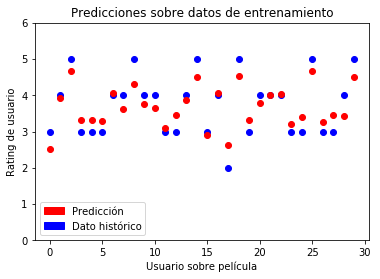

In [13]:
%matplotlib inline
training_pred_df = training_df.copy()
for i in range(len(trainset_as_testset[0:30])):
    training_pred_df.loc[i, 'rating'] = gs.predict(trainset_as_testset[i][0], trainset_as_testset[i][1])[3]
    
f, ax = plt.subplots(1)
plt.plot(training_df[0:30].index.values, training_df[0:30]['rating'], 'bo', 
         training_df[0:30].index.values, training_pred_df[0:30]['rating'], 'ro')
ax.set_title('Predicciones sobre datos de entrenamiento')
ax.set_ylim(ymin=0, ymax=6)
ax.set_xlabel('Usuario sobre película')
ax.set_ylabel('Rating de usuario')
red_patch = mpatches.Patch(color='red', label='Predicción')
blue_patch = mpatches.Patch(color='blue', label='Dato histórico')
plt.legend(handles=[red_patch, blue_patch])
plt.show(f)

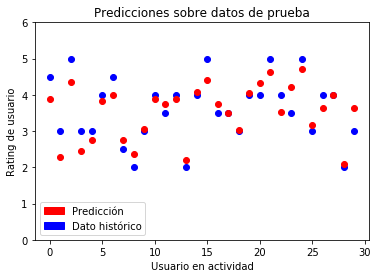

In [12]:
test_df = pd.DataFrame(testset, columns=['usuario','evento','rating'])
prediction_df = pd.DataFrame(testset, columns=['usuario','evento','rating'])
for i in range(len(testset[0:30])):
    prediction_df.loc[i, 'rating'] = gs.predict(testset[i][0], testset[i][1])[3]
    
f, ax = plt.subplots(1)
plt.plot(test_df.index.values[0:30], test_df[0:30]['rating'], 'bo', 
         test_df.index.values[0:30], prediction_df[0:30]['rating'], 'ro')
ax.set_ylim(ymin=0, ymax=6)
ax.set_title('Predicciones sobre datos de prueba')
ax.set_xlabel('Usuario en actividad')
ax.set_ylabel('Rating de usuario')
red_patch = mpatches.Patch(color='red', label='Predicción')
blue_patch = mpatches.Patch(color='blue', label='Dato histórico')
plt.legend(handles=[red_patch, blue_patch])
plt.show(f)